In [24]:
import sys
import os
# Add workspace root to Python path for imports
'''
By default, Python only searches for modules in the current directory and installed packages. 
Since your notebook is in the notebooks subfolder, you need to add the parent folder (your workspace root) to the Python path. 
This lets you import modules like open_ephys_loader or pfr_neurofunctions dirm ectly.
'''
workspace_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, workspace_root)
# Now you can import modules from your workspace directly

In [ ]:
from open_ephys_loader import load_openephys_dat_lazy_with_tetrodes

# Your tetrode setup - NOW PRESERVED!
tetrode_groups = {
    'CA1': {'tet1': [17, 18, 19, 20], 'tet2': [21, 22, 23, 24]},
    'RTC': {'tet1': [14, 15, 16]},
    'PFC': {'tet1': [0, 1, 2, 3], 'tet2': [4, 5, 6, 7]},
}

selected_channels = {
    'CA1_tet1': 17, 'CA1_tet2': 21, 'RTC_tet1': 14,
    'PFC_tet1': 0, 'PFC_tet2': 5
}

data_lfp = load_openephys_dat_lazy_with_tetrodes(
    filepath=r"F:\Spikeinterface_practice\s4_rec\ephys.dat",
    num_channels=43,
    tetrode_groups=tetrode_groups,
    selected_channels=selected_channels,
    sampling_frequency=30000,
    target_sampling_frequency=1000,
    plot='widget',
    verbose=False
)
display(data_lfp)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

loader = data_lfp.loader # not sure why I need to do that, but it looks like the widget option doenst allow to get the physical recording and this solve the problem
start, end = 0, 5
trace = loader.get_selected_trace('CA1_tet1', start_time=start, end_time=end, resample_to=1000)
fs = trace.size / (end - start)
# trace = np.asarray(loader.get_selected_trace('CA1_tet1', start_time=0, end_time=5))
# fs = getattr(loader, "target_sampling_frequency", None)
t = np.arange(trace.size) / fs

plt.figure(figsize=(10, 4))
plt.plot(t, trace, lw=0.6)
plt.xlabel("Time (s)")
plt.ylabel("CA1_tet1")
plt.tight_layout()

Step 1: Load and Inspect Spike Data__

In [ ]:
import numpy as np
from pathlib import Path
from spike_analysis import SpikeAnalysis, process_spike_data, load_processed_spike_data

# Process to generate 'units.npy'
npy_path = r'F:\Spikeinterface_practice\s4_rec\phyMS5' # Path to the directory containing the analsis from  phy2
save_path = r'F:\Spikeinterface_practice\s4_rec'
process_spike_data(npy_path, save_path, samp_freq=30000)

# After running process_spike_data once, load cleanly without manual fixes:
units_file = r'F:\Spikeinterface_practice\s4_rec\units.npy'
processed_spike_data = load_processed_spike_data(units_file)

# Now pass directly to SpikeAnalysis
spike_analysis = SpikeAnalysis(
    processed_data=processed_spike_data,
    sampling_rate=30000,
    duration=data_lfp.duration
)

region_mapping = {2: 'PFC',
                  3: 'PFC',
                  7: 'CA1',
                  8: 'CA1',
                  6: 'RTC'}
spike_analysis.assign_brain_regions(region_mapping)

# Verify the mapping
for tetrode, region in region_mapping.items():
    units_in_tetrode = spike_analysis.tetrode_mapping.get(tetrode, [])
    print(f"Tetrode {tetrode} ({region}): {len(units_in_tetrode)} units")


In [ ]:
# Import or copy the fixed function
from open_ephys_loader.brain_regions import plot_region_lfp_with_spike_raster
# Or customize colors
custom_colors = {
    'CA1': '#FF6B6B',  # Red
    'RTC': '#4ECDC4',  # Teal  
    'PFC': '#45B7D1',  # Blue
}

# loader = data_lfp.loader # optional, otherwise needs to run load_openephys_dat_lazy_with_tetrodes with plot=False
# Widget mode - interactive navigation
plot_region_lfp_with_spike_raster(
    loader, 
    selected_channels, 
    tetrode_groups, 
    spike_analysis, 
    regions=['CA1', 'RTC', 'PFC'],
    widget_mode=True,  # ✅ Now works with firing rate!
    window_size=2.0,
    show_firing_rate=True,
    firing_rate_kernel_width=0.06,
    region_colors=custom_colors
)


In [ ]:
from position_analysis import (
    load_position_data,
    interpolate_position,
    estimate_velocity,
    plot_position_data,
    create_track_graph,
    linearize_positions_along_graph,
)

# Load
tvel, linVel = load_position_data(r'F:\DataAnalysis\hpRetPFC1\S4\position\PositionData.mat', position_key='linVel', return_time=True)
t_lfp=t
_, velocity = interpolate_position(tvel, linVel.squeeze(), target_vector=t_lfp)

# Import the function (adjust the import path if needed)
from position_analysis.plotting import plot_interpolation_alignment, plot_interpolation_corr

# Call the function with your variables
corr_pos, corr_lfp = plot_interpolation_alignment(
    tvel, linVel, t_lfp, velocity, show=True
)

corr_pos, corr_lfp = plot_interpolation_corr(
    tvel, linVel, t_lfp, velocity, show=True
)

print(f"Correlation (pos timeline): {corr_pos:.4f}")
print(f"Correlation (LFP timeline): {corr_lfp:.4f}")

### SWR detection and stats (library-based)

In [25]:
# Single- and multi-region SWR detection + summary plots

# 0) Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from open_ephys_loader import fast_openephys_dat_lfp
from position_analysis import load_position_data, interpolate_position
from swr_detection import SWRParams, SWRDetector
from swr_detection.pipeline import (
    find_region_channels,
    build_region_lfp,
    compute_immobility_mask,
    detect_swr_by_region,
    quick_overlay_plot,
    compute_region_mua_from_spikes,   # optional (spikes → region MUA)
    _get_unit_spike_times             # optional (if using SpikeAnalysis)
)


# 1) User config
dat_path = r"D:\Spikeinterface_practice\s4_rec\ephys.dat"              # EDIT
num_channels = 43                                                      # EDIT
selected_channels = {                                                  # EDIT
    'CA1_tet1': 17, 'CA1_tet2': 21, 'RTC_tet1': 14, 'PFC_tet1': 0, 'PFC_tet2': 5
}
fs_in = 30000.0
fs_out = 1000.0  # 1 kHz is sufficient for 150–250 Hz ripple band
pos_mat_path = r"D:\DataAnalysis\hpRetPFC1\S4\position\PositionData.mat"  # position path, matlab processed
pos_key = "linVel"  # velocity (or change to the right key in your .mat)

# 2) Load downsampled LFP
loader = fast_openephys_dat_lfp(
    filepath=dat_path,
    num_channels=num_channels,
    tetrode_groups={},             # not used in fast loader
    selected_channels=selected_channels,
    sampling_frequency=fs_in,
    target_sampling_frequency=fs_out,
    cache_dir=None,
    dtype="int16",
    chunk_sec=120.0,
    overlap_sec=0.25,
    return_mode="loader",
)
fs = float(loader.sampling_frequency)
t_lfp = loader.time_vector()
print(f"LFP duration: {loader.duration:.2f}s at {fs:.1f} Hz")

LFP duration: 2993.56s at 1000.0 Hz


3) Velocity aligned to LFP timeline + immobility mask

In [ ]:
# from position_analysis import (
#     load_position_data,
#     interpolate_position,
# )
# t_pos, vel_pos = load_position_data(pos_mat_path, position_key=pos_key, return_time=True)
# _, velocity = interpolate_position(
#     np.asarray(t_pos).squeeze(),
#     np.asarray(vel_pos).squeeze(),
#     target_vector=np.asarray(t_lfp).squeeze(),
# )
# immobile = compute_immobility_mask(velocity, v_thresh=5.0)

4) Build per-region LFP arrays

In [26]:
region_channels = find_region_channels(list(getattr(loader, "selected_channels", {}).keys()))
region_lfp = build_region_lfp(loader, region_channels) # Obtain the LFP for each region
print({k: v.shape for k, v in region_lfp.items()})

{'CA1': (2, 2993562), 'RTC': (1, 2993562), 'PFC': (2, 2993562)}


Tetrode 7 (CA1): 3 units
Tetrode 8 (CA1): 3 units
Tetrode 6 (RTC): 1 units
Tetrode 2 (PFC): 4 units
Tetrode 3 (PFC): 6 units
CA1 MUA shape: (2993562,) (should match LFP length: 2993562)
RTC MUA shape: (2993562,) (should match LFP length: 2993562)
PFC MUA shape: (2993562,) (should match LFP length: 2993562)


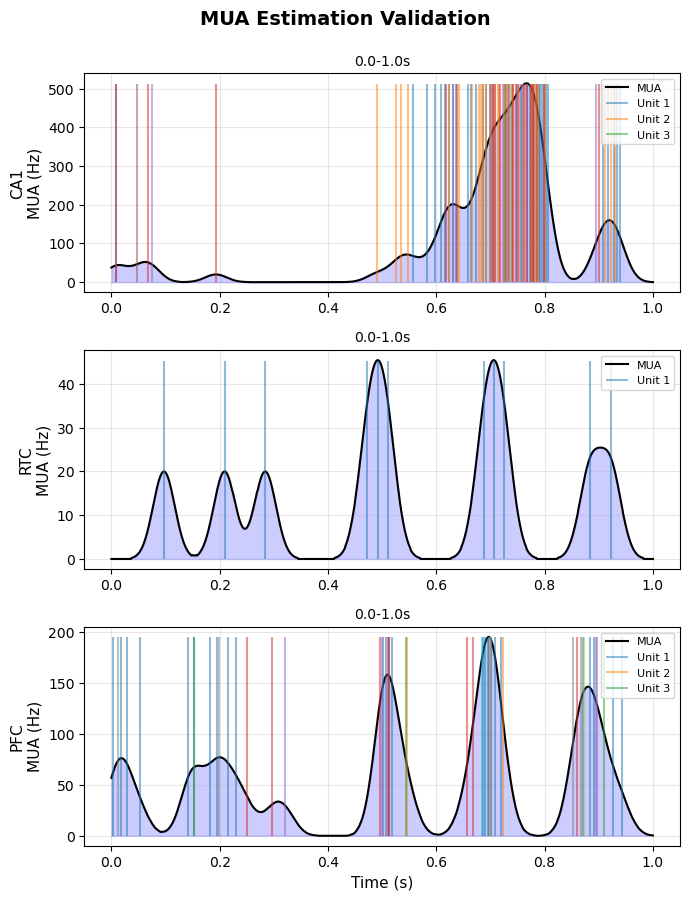

In [27]:
# 1. Setup (as before)
from spike_analysis import SpikeAnalysis, load_processed_spike_data

units_file = r'D:\Spikeinterface_practice\s4_rec\units.npy'
processed_data = load_processed_spike_data(units_file)

spike_analysis = SpikeAnalysis(
    processed_data=processed_data,
    sampling_rate=30000,
    duration=loader.duration
)

region_mapping = {7: 'CA1', 
                  8: 'CA1', 
                  6: 'RTC', 
                  2: 'PFC', 
                  3: 'PFC'}
spike_analysis.assign_brain_regions(region_mapping)
# Verify the mapping
for tetrode, region in region_mapping.items():
    units_in_tetrode = spike_analysis.tetrode_mapping.get(tetrode, [])
    print(f"Tetrode {tetrode} ({region}): {len(units_in_tetrode)} units")

# 2. NEW: Compute MUA (replaces manual extraction)
t_lfp = loader.time_vector()
mua_by_region = spike_analysis.compute_mua_all_regions(
    t_lfp=t_lfp,
    kernel_width=0.02
)

# Step 3: Verify MUA shapes match your LFP
for region, mua_vec in mua_by_region.items():
    print(f"{region} MUA shape: {mua_vec.shape} (should match LFP length: {len(t_lfp)})")

# Step 4: Use in single-region SWRDetector (example for CA1)
region = "CA1"
lfp_array = region_lfp[region]
mua_vec = mua_by_region[region]  # Now you have this!

#3. NEW: Visualize for validation
fig = spike_analysis.visualize_mua_segments(
    mua_by_region=mua_by_region,
    t_lfp=t_lfp,
    windows=[(0, 1)],
    show_spikes=True
)
plt.show()


Initialized SWR detector with 2 channels and 2993.56 seconds of data

Current Detection Parameters:

Core Parameters:
Ripple band: (125, 250) Hz
Threshold multiplier: 2.25 SD
Duration limits: 0.03-0.4 s

Signal Processing:
Notch frequency: 60 Hz
Sharp wave band: Disabled Hz
Trace window: 1.0 s

Event Detection:
Duration std threshold: 0.1 SD
Minimum event separation: 0.07 s
Merge threshold: 0.8

Classification Parameters:
Single separation: 200 ms
Burst intervals: 70-200 ms
Merge interval: 70 ms

MUA Parameters:
MUA detection: Enabled
MUA threshold: 3 SD
MUA min duration: 30 ms

HMM Edge Detection:
Use HMM edge detection: True
HMM margin: 0.01 s
HMM states (ripple): 3
HMM states (MUA): 2
Use global HMM: True (fraction=0.1)
Use multivariate HMM: False
Z-score MUA: False

Movement Filtering:
Velocity threshold: None cm/s

Data Information:
Number of channels: 2
Recording duration: 2993.56 s
Sampling rate: 1000.0 Hz
MUA data: Provided
Velocity data: Not provided
[Global HMM Training] Sam

c:\Users\pdrmwl\miniconda3\envs\neuro_analysis\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\pdrmwl\miniconda3\envs\neuro_analysis\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\pdrmwl\miniconda3\envs\neuro_analysis\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\pdrmwl\miniconda3\envs\neuro_analysis\Lib\site-packages\sklea

[HMM Edge Detection] Using standard 3-state mode: shoulder+core (states 1,2)


c:\Users\pdrmwl\miniconda3\envs\neuro_analysis\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\pdrmwl\miniconda3\envs\neuro_analysis\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\pdrmwl\miniconda3\envs\neuro_analysis\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\pdrmwl\miniconda3\envs\neuro_analysis\Lib\site-packages\sklea

Detected 1765 events

Improved Classification Summary:
Singles: 1353
Doubles: 125
Triples: 13
Multiples: 2
Analyzing basic statistics...
Analysis complete. Found 1650 total consensus events.

--- SWR Basic Statistics Summary ---

Event Type Counts (Consensus):
  - Ripple & MUA:       479
  - Ripple Only:        1066
  - MUA Only:           105

HMM-Detected Event Counts:
  - HMM Ripple Edges:   1545
  - HMM MUA Edges:      1650

Consensus Event Durations (by Classification):
  - Single (N=1353):
      Mean: 69.50 ms, Median: 70.00 ms
  - Double (N=250):
      Mean: 67.19 ms, Median: 68.00 ms
  - Triple (N=39):
      Mean: 63.87 ms, Median: 66.00 ms
  - Multiple (N=8):
      Mean: 57.37 ms, Median: 59.50 ms
  - Unclassified (N=0)

HMM-Edge Event Durations:
  - HMM Ripple (N=1545):
      Mean: 49.58 ms, Median: 50.00 ms
  - HMM MUA (N=1650):
      Mean: 68.96 ms, Median: 68.00 ms
--------------------------------------



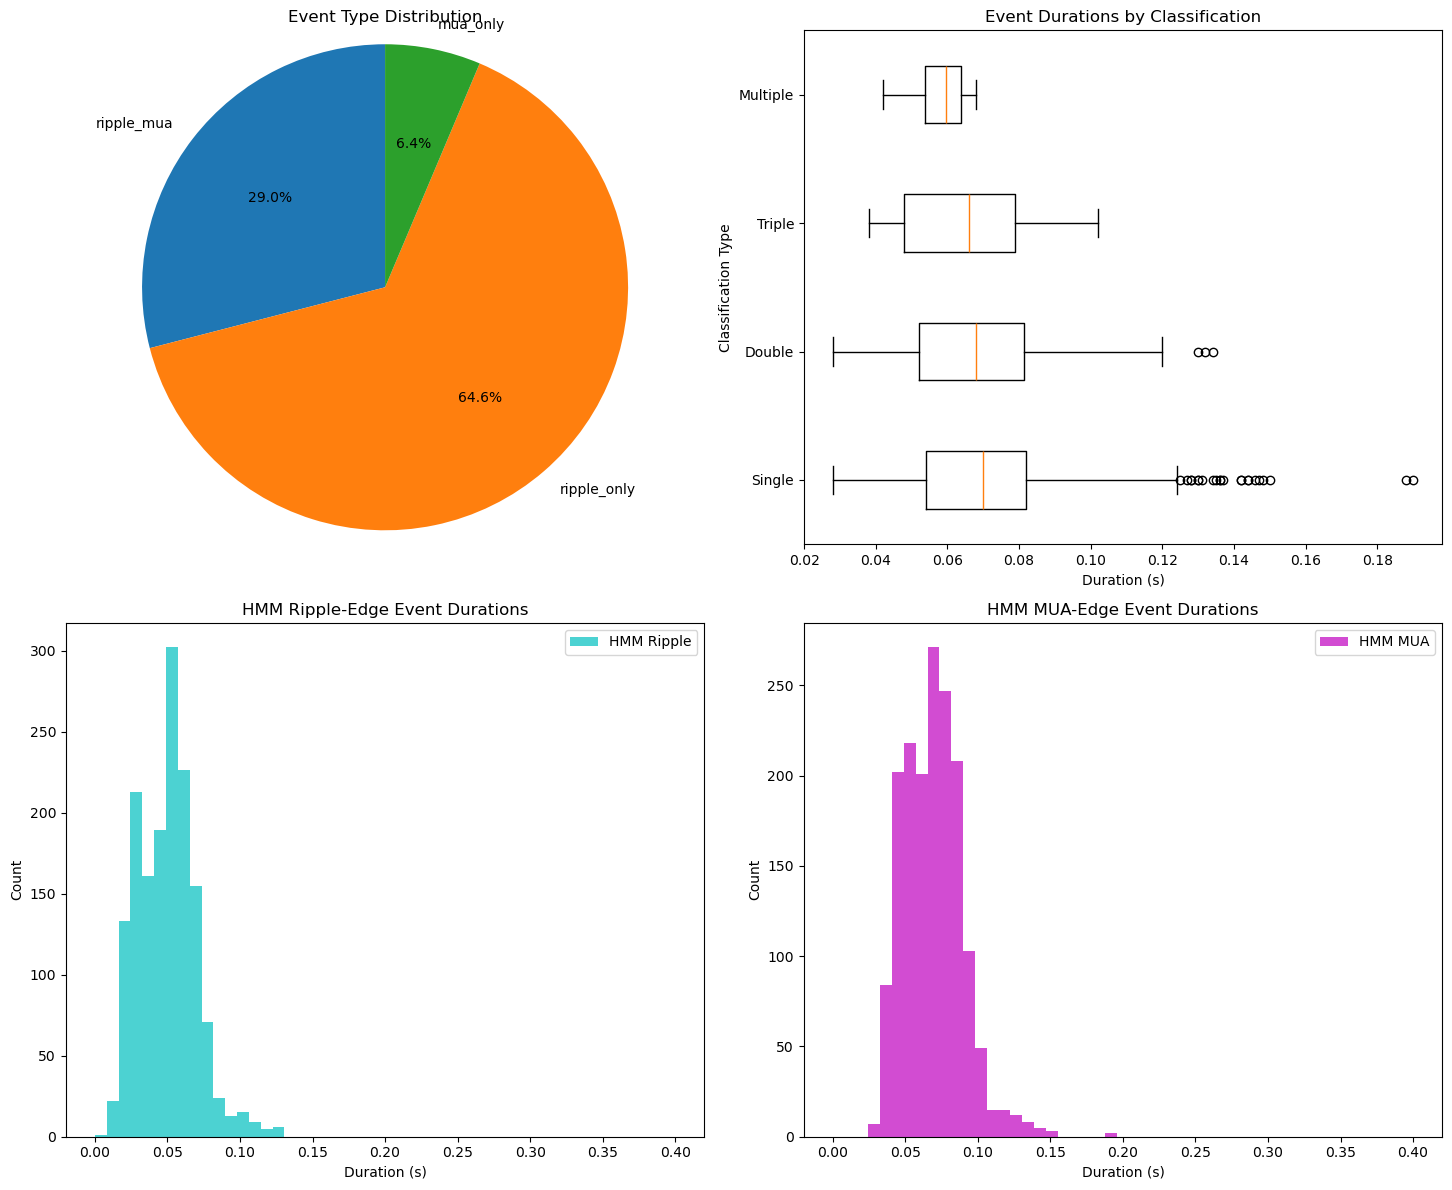

In [28]:

import importlib
import swr_detection.swr_hmm_detection as _swr_hmm
importlib.reload(_swr_hmm)
from swr_detection.swr_hmm_detection import SWRHMMParams, SWRHMMDetector

# params = SWRHMMParams(
#     ripple_band=(125, 250),           # or your preferred band
#     threshold_multiplier=2.25,
#     min_duration=0.03,
#     max_duration=0.4,
#     duration_std_threshold=0.1,
#     min_event_separation=0.07,
#     velocity_threshold=None,
#     mua_threshold_multiplier=3,
#     mua_min_duration=0.03,
#     enable_mua=True,
#     merge_interval=0.07,
#     trace_window=1.0,

#     use_hmm_edge_detection=True,      # Enable HMM edge detection
#     hmm_margin=0.01,
#     use_global_hmm=True,              # <--- Enable global HMM
#     global_hmm_fraction=0.1,          # Fraction of data to use for global HMM training
#     use_multivariate_hmm=True,        # enable joint ripple+MUA HMM
#     hmm_states_ripple=2,              # Ripple power HMM states
#     hmm_states_mua=3,                 # MUA HMM states (change only this for MUA)

#     use_mua_derivative=True,
#     derivative_sigma=1,  # Try 0.5, 1, or 1.5 (current default is 2)
#     use_robust_init=True,
#     zscore_mua=True
# )

params = SWRHMMParams(
    ripple_band=(125, 250),
    threshold_multiplier=2.25,
    min_duration=0.03,
    max_duration=0.4,
    min_event_separation=0.07,
    mua_threshold_multiplier=3,
    mua_min_duration=0.03,
    enable_mua=True,
    merge_interval=0.07,
    trace_window=1.0,
    use_hmm_edge_detection=True,
    hmm_margin=0.01,
    use_global_hmm=True,
    global_hmm_fraction=0.1,
    hmm_states_ripple=3,
    hmm_states_mua=2
)

# --- Initialize detector ---
detector = SWRHMMDetector(
    lfp_data=lfp_array,   # shape: (n_channels, n_samples)
    fs=fs,
    mua_data=mua_vec,     # shape: (n_samples,)
    params=params
)

# --- Detect events (global HMM will be trained automatically if enabled) ---
# detector.detect_events(channels='all', average_mode=True) # 
detector.detect_events(channels=[0], average_mode=False)
detector.classify_events_improved()
stats = detector.analyze_basic_stats()
detector.plot_basic_stats(stats)

In [39]:
# Prepare spike_times_by_region format (CA1 only, since detector is for CA1)
spike_times_ca1_only = {}
region = 'CA1'  # Match the detector's region
spike_list = spike_analysis.get_spike_times_by_region(region)
region_units = spike_analysis.get_units_by_region(region)

# Create dictionary mapping unit_id -> spike_times for CA1 only
spike_times_ca1_only[region] = {
    unit_id: np.asarray(spike_times).flatten()  # Add .flatten()
    for unit_id, spike_times in zip(region_units, spike_list)
}

print(f"Spike data prepared for {region}: {len(spike_times_ca1_only[region])} units")

# Custom region color (only CA1 needed)
custom_colors = {
    'CA1': '#FF6B6B',  # Red
}

# Launch enhanced visualization for CA1 events
detector.visualize_events(
    spike_times_by_region=spike_times_ca1_only,  # Only CA1 spike data
    region_colors=custom_colors,
    remove_spines=True
)

print(f"\nViewing CA1 events (Total: {len(detector.swr_events)})")

Spike data prepared for CA1: 6 units



INTERACTIVE SWR EVENT BROWSER

Navigation Controls:
  • Click 'Previous' and 'Next' buttons to browse events
  • Type event number directly in the input box
  • Adjust 'Window (s)' slider to change event window length

Features:
  ✓ Dynamic window adjustment (prevents trace overflow)
  ✓ Region-colored spike rasters (if spike_times_by_region provided)
  ✓ Clean axes without box spines
  ✓ Enhanced multi-panel visualization
  ✓ HMM MUA boundary visualization (magenta shading)

Total Events: 1650


Viewing CA1 events (Total: 1650)


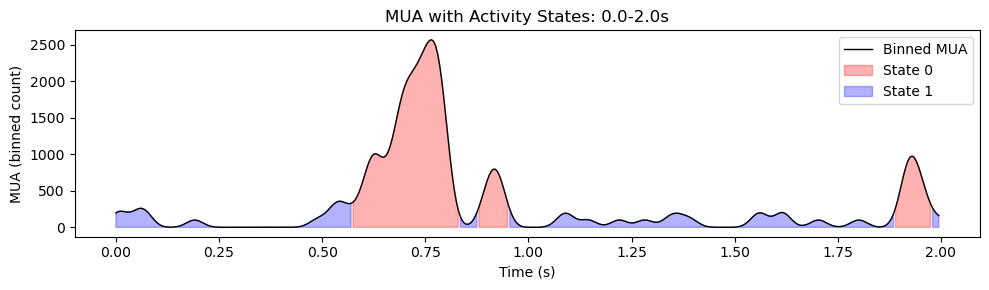

In [30]:
from swr_detection.mua_high_activity_refinement import (
    bin_mua,
    train_hmm_on_mua,
    extract_high_activity_periods,
    refine_event_with_mua_states,
    refine_all_events_with_mua_states,
    expand_state_edges,
    refine_event_with_global_states,
    refine_all_events_with_global_hmm,
    interactive_mua_state_browser
)
# 1. Bin MUA
bin_size = 0.005  # 5 ms bins
mua_binned = bin_mua(mua_vec, bin_size=bin_size, fs=fs)

# 2. Train HMM/HSMM
model = train_hmm_on_mua(mua_binned, n_states=2, params=params)

# 3. Infer state sequence
states = model.predict(mua_binned.reshape(-1, 1))

# 4. Detect high activity periods
high_periods = extract_high_activity_periods(states, bin_size=bin_size, fs=fs)
# After you have mua_binned and states
states_expanded = expand_state_edges(states, target_state=0, expand_bins=0)
interactive_mua_state_browser(mua_binned, states_expanded, bin_size=bin_size, window_sec=2)

In [42]:
# Step 1: Refine ALL events with MUA using extended search window
from swr_detection.mua_high_activity_refinement import refine_all_events_with_global_hmm

refined_events = refine_all_events_with_global_hmm(
    detector.swr_events, 
    mua_vec, 
    fs, 
    bin_size=0.005,        # 5ms bins
    n_states=2,            # 2-state HMM (low/high activity)
    search_margin=0.2,     # Search ±200ms around ripple
    expand_bins=0          # Optional: add more bins for additional expansion
)

print(f"✓ Refined {len(refined_events)} events with MUA-based boundaries")
print(f"  - Search margin: ±{0.2*1000:.0f}ms around ripple boundaries")
print(f"  - Bin size: {0.005*1000:.1f}ms")
print(f"\nUse the interactive browser below to explore events with spike rasters!")

✓ Refined 1650 events with MUA-based boundaries
  - Search margin: ±200ms around ripple boundaries
  - Bin size: 5.0ms

Use the interactive browser below to explore events with spike rasters!


### MUA-Based SWR Event Boundary Refinement

The following cells refine SWR event boundaries using Multi-Unit Activity (MUA) high/low activity states detected by a Hidden Markov Model (HMM).

**Key Features:**
- **Extended Search Window**: Searches ±200ms around ripple boundaries to capture full MUA extent
- **Global HMM**: Trains once on entire recording for stable state detection
- **Peak-Centered**: Finds high-activity segment containing the ripple peak
- **Spike Raster Visualization**: Compare ripple HMM vs. MUA-refined boundaries with unit activity

**Workflow:**
1. ✅ Bin MUA into 5ms windows
2. ✅ Train 2-state HMM (low/high activity) on full recording
3. ✅ For each event, find high-activity segment in extended window
4. ✅ Visualize with spike rasters showing both boundary types

In [40]:
# Reload the module to get the latest changes
import importlib
import swr_detection.mua_high_activity_refinement
importlib.reload(swr_detection.mua_high_activity_refinement)

<module 'swr_detection.mua_high_activity_refinement' from 'c:\\Users\\pdrmwl\\OneDrive - Massachusetts Institute of Technology\\pfr_neurophys_data_analysis\\swr_detection\\mua_high_activity_refinement.py'>

In [41]:
# Interactive browser with spike raster plots showing MUA-refined boundaries
from swr_detection.mua_high_activity_refinement import interactive_event_refinement_with_spikes

# Prepare spike_times_by_region format (CA1 only, since detector is for CA1)
spike_times_ca1_only = {}
region = 'CA1'  # Match the detector's region
spike_list = spike_analysis.get_spike_times_by_region(region)
region_units = spike_analysis.get_units_by_region(region)

# Create dictionary mapping unit_id -> spike_times for CA1 only
spike_times_ca1_only[region] = {
    unit_id: np.asarray(spike_times).flatten()
    for unit_id, spike_times in zip(region_units, spike_list)
}

print(f"Spike data prepared for {region}: {len(spike_times_ca1_only[region])} units")

# Custom region color (only CA1 needed)
custom_colors = {
    'CA1': '#FF6B6B',  # Red
}

# Launch enhanced visualization with spike rasters
interactive_event_refinement_with_spikes(
    detector, 
    mua_vec, 
    spike_times_ca1_only,
    region_colors=custom_colors,
    margin=0.5
)

Spike data prepared for CA1: 6 units


In [43]:
# Check what's stored in the events - both ripple and MUA boundaries are saved!
event = detector.swr_events[0]

print("=" * 60)
print("EVENT BOUNDARY INFORMATION")
print("=" * 60)
print("\n📊 Original Ripple Power HMM Detection:")
print(f"   Start: {event.get('combined_start_time', event.get('start_time')):.4f}s")
print(f"   End:   {event.get('combined_end_time', event.get('end_time')):.4f}s")
print(f"   Duration: {event.get('duration', 0)*1000:.1f}ms")

print("\n🔥 MUA-Refined Boundaries (NEW):")
print(f"   Start: {event.get('mua_high_start'):.4f}s")
print(f"   End:   {event.get('mua_high_end'):.4f}s")
mua_duration = event.get('mua_high_end') - event.get('mua_high_start')
print(f"   Duration: {mua_duration*1000:.1f}ms")

print("\n📈 Other Available Data:")
print(f"   Peak time: {event.get('peak_time'):.4f}s")
print(f"   Peak power: {event.get('peak_power'):.2f}")
print(f"   Channel: {event.get('channel')}")
print(f"   Event ID: {event.get('event_id')}")

print("\n✅ Both boundary types are permanently stored in detector.swr_events!")
print("   You can access them anytime for analysis or export.")

EVENT BOUNDARY INFORMATION

📊 Original Ripple Power HMM Detection:
   Start: 0.7500s
   End:   0.8000s
   Duration: 129.0ms

🔥 MUA-Refined Boundaries (NEW):
   Start: 0.5800s
   End:   0.8300s
   Duration: 250.0ms

📈 Other Available Data:
   Peak time: 0.7760s
   Peak power: 6286.06
   Channel: 0
   Event ID: 1

✅ Both boundary types are permanently stored in detector.swr_events!
   You can access them anytime for analysis or export.



DURATION COMPARISON: RIPPLE HMM vs MUA-REFINED BOUNDARIES

Total events analyzed: 1650

Duration Statistics (ms):

          Metric       Mean    Median        Std       Min      Max
Ripple Power HMM  68.958788  68.00000  20.164914  28.00000  190.000
     MUA Refined 269.209091 275.00000 124.311298  45.00000  590.000
       Extension 200.250303 203.50000 124.028466 -32.00000  405.000
   Extension (%) 320.452213 281.46744 229.138398 -39.02439 1259.375


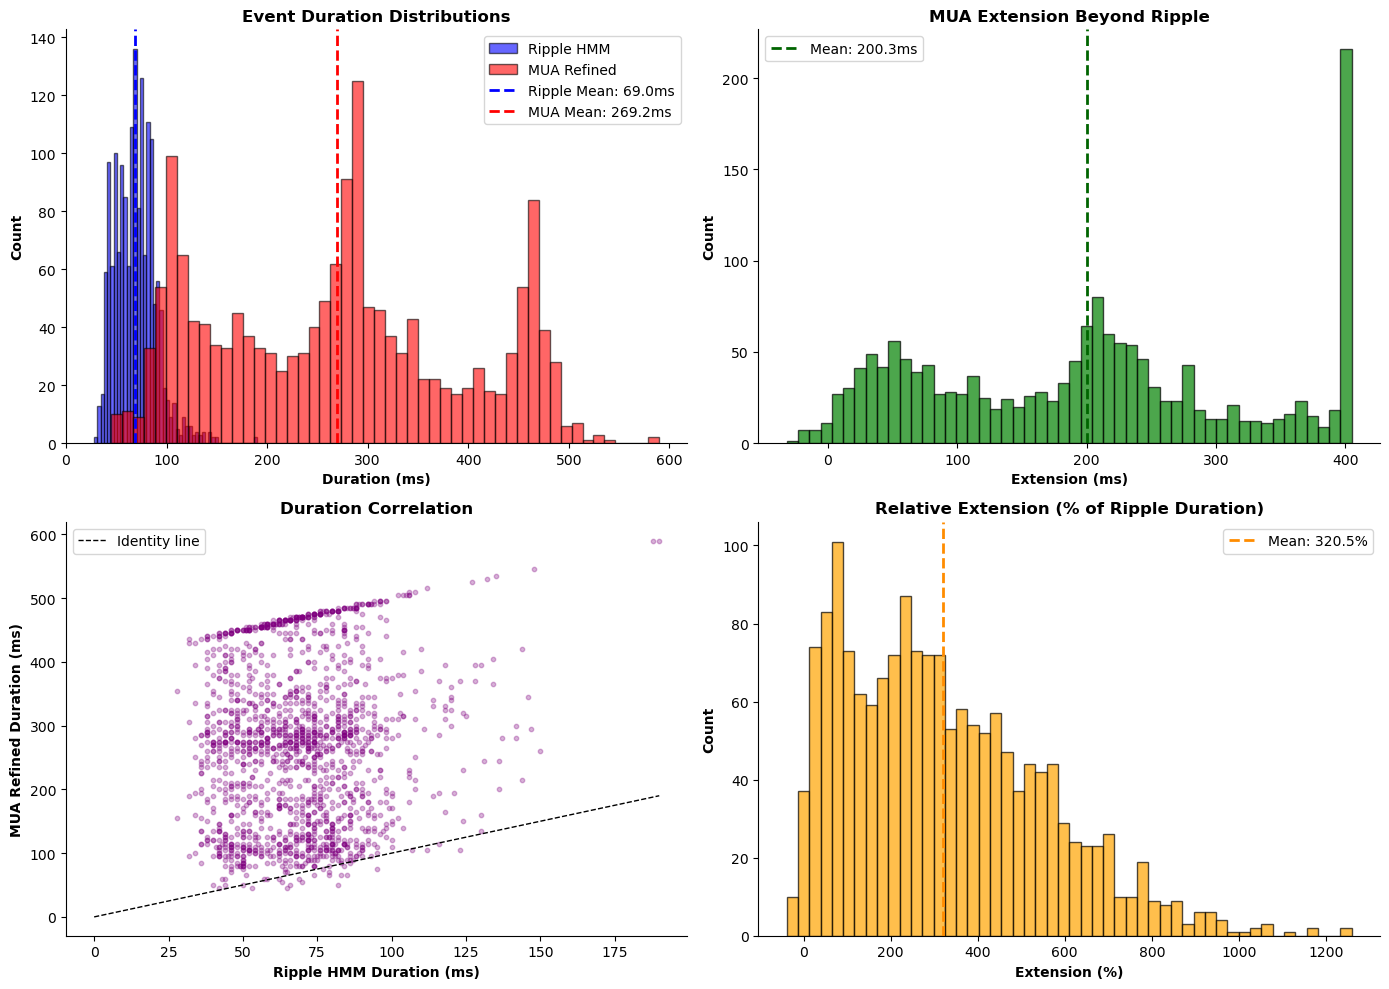


✅ Both boundary types are stored in detector.swr_events for each event:
   - Ripple: event['combined_start_time'], event['combined_end_time']
   - MUA:    event['mua_high_start'], event['mua_high_end']


In [44]:
# Analyze duration differences across all events
import pandas as pd

# Extract both duration types from all events
ripple_durations = []
mua_durations = []
extensions = []
extension_percentages = []

for event in detector.swr_events:
    ripple_start = event.get('combined_start_time', event.get('start_time'))
    ripple_end = event.get('combined_end_time', event.get('end_time'))
    mua_start = event.get('mua_high_start')
    mua_end = event.get('mua_high_end')
    
    if ripple_start and ripple_end and mua_start and mua_end:
        ripple_dur = (ripple_end - ripple_start) * 1000  # Convert to ms
        mua_dur = (mua_end - mua_start) * 1000
        extension = mua_dur - ripple_dur
        extension_pct = (extension / ripple_dur) * 100
        
        ripple_durations.append(ripple_dur)
        mua_durations.append(mua_dur)
        extensions.append(extension)
        extension_percentages.append(extension_pct)

# Create summary statistics
summary_df = pd.DataFrame({
    'Metric': ['Ripple Power HMM', 'MUA Refined', 'Extension', 'Extension (%)'],
    'Mean': [
        np.mean(ripple_durations),
        np.mean(mua_durations),
        np.mean(extensions),
        np.mean(extension_percentages)
    ],
    'Median': [
        np.median(ripple_durations),
        np.median(mua_durations),
        np.median(extensions),
        np.median(extension_percentages)
    ],
    'Std': [
        np.std(ripple_durations),
        np.std(mua_durations),
        np.std(extensions),
        np.std(extension_percentages)
    ],
    'Min': [
        np.min(ripple_durations),
        np.min(mua_durations),
        np.min(extensions),
        np.min(extension_percentages)
    ],
    'Max': [
        np.max(ripple_durations),
        np.max(mua_durations),
        np.max(extensions),
        np.max(extension_percentages)
    ]
})

print("\n" + "=" * 80)
print("DURATION COMPARISON: RIPPLE HMM vs MUA-REFINED BOUNDARIES")
print("=" * 80)
print(f"\nTotal events analyzed: {len(ripple_durations)}")
print("\nDuration Statistics (ms):\n")
print(summary_df.to_string(index=False))

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Duration distributions
axes[0, 0].hist(ripple_durations, bins=50, alpha=0.6, color='blue', label='Ripple HMM', edgecolor='black')
axes[0, 0].hist(mua_durations, bins=50, alpha=0.6, color='red', label='MUA Refined', edgecolor='black')
axes[0, 0].axvline(np.mean(ripple_durations), color='blue', linestyle='--', linewidth=2, label=f'Ripple Mean: {np.mean(ripple_durations):.1f}ms')
axes[0, 0].axvline(np.mean(mua_durations), color='red', linestyle='--', linewidth=2, label=f'MUA Mean: {np.mean(mua_durations):.1f}ms')
axes[0, 0].set_xlabel('Duration (ms)', fontweight='bold')
axes[0, 0].set_ylabel('Count', fontweight='bold')
axes[0, 0].set_title('Event Duration Distributions', fontweight='bold', fontsize=12)
axes[0, 0].legend()
axes[0, 0].spines['top'].set_visible(False)
axes[0, 0].spines['right'].set_visible(False)

# 2. Extension distribution
axes[0, 1].hist(extensions, bins=50, alpha=0.7, color='green', edgecolor='black')
axes[0, 1].axvline(np.mean(extensions), color='darkgreen', linestyle='--', linewidth=2, label=f'Mean: {np.mean(extensions):.1f}ms')
axes[0, 1].set_xlabel('Extension (ms)', fontweight='bold')
axes[0, 1].set_ylabel('Count', fontweight='bold')
axes[0, 1].set_title('MUA Extension Beyond Ripple', fontweight='bold', fontsize=12)
axes[0, 1].legend()
axes[0, 1].spines['top'].set_visible(False)
axes[0, 1].spines['right'].set_visible(False)

# 3. Scatter plot: Ripple vs MUA duration
axes[1, 0].scatter(ripple_durations, mua_durations, alpha=0.3, s=10, color='purple')
axes[1, 0].plot([0, max(ripple_durations)], [0, max(ripple_durations)], 'k--', linewidth=1, label='Identity line')
axes[1, 0].set_xlabel('Ripple HMM Duration (ms)', fontweight='bold')
axes[1, 0].set_ylabel('MUA Refined Duration (ms)', fontweight='bold')
axes[1, 0].set_title('Duration Correlation', fontweight='bold', fontsize=12)
axes[1, 0].legend()
axes[1, 0].spines['top'].set_visible(False)
axes[1, 0].spines['right'].set_visible(False)

# 4. Extension percentage distribution
axes[1, 1].hist(extension_percentages, bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[1, 1].axvline(np.mean(extension_percentages), color='darkorange', linestyle='--', linewidth=2, label=f'Mean: {np.mean(extension_percentages):.1f}%')
axes[1, 1].set_xlabel('Extension (%)', fontweight='bold')
axes[1, 1].set_ylabel('Count', fontweight='bold')
axes[1, 1].set_title('Relative Extension (% of Ripple Duration)', fontweight='bold', fontsize=12)
axes[1, 1].legend()
axes[1, 1].spines['top'].set_visible(False)
axes[1, 1].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

print("\n✅ Both boundary types are stored in detector.swr_events for each event:")
print("   - Ripple: event['combined_start_time'], event['combined_end_time']")
print("   - MUA:    event['mua_high_start'], event['mua_high_end']")

In [45]:
# Export both boundary types to CSV for further analysis
export_data = []

for i, event in enumerate(detector.swr_events):
    ripple_start = event.get('combined_start_time', event.get('start_time'))
    ripple_end = event.get('combined_end_time', event.get('end_time'))
    mua_start = event.get('mua_high_start')
    mua_end = event.get('mua_high_end')
    
    if ripple_start and ripple_end and mua_start and mua_end:
        ripple_dur = (ripple_end - ripple_start) * 1000
        mua_dur = (mua_end - mua_start) * 1000
        extension = mua_dur - ripple_dur
        
        export_data.append({
            'event_id': event.get('event_id', i),
            'channel': event.get('channel'),
            'peak_time': event.get('peak_time'),
            'peak_power': event.get('peak_power'),
            # Ripple boundaries
            'ripple_start_time': ripple_start,
            'ripple_end_time': ripple_end,
            'ripple_duration_ms': ripple_dur,
            # MUA boundaries
            'mua_start_time': mua_start,
            'mua_end_time': mua_end,
            'mua_duration_ms': mua_dur,
            # Comparison
            'extension_ms': extension,
            'extension_percent': (extension / ripple_dur) * 100
        })

# Create DataFrame
events_df = pd.DataFrame(export_data)

# Display first few events
print("\n" + "=" * 80)
print("EXPORTED EVENT DATA WITH BOTH BOUNDARY TYPES")
print("=" * 80)
print(f"\nTotal events: {len(events_df)}\n")
print(events_df.head(10).to_string(index=False))

# Save to CSV (optional - uncomment to save)
# output_path = r"D:\Spikeinterface_practice\s4_rec\swr_events_with_mua_boundaries.csv"
# events_df.to_csv(output_path, index=False)
# print(f"\n✅ Saved to: {output_path}")

print("\n📊 Quick Summary:")
print(f"   Average ripple duration: {events_df['ripple_duration_ms'].mean():.1f} ms")
print(f"   Average MUA duration: {events_df['mua_duration_ms'].mean():.1f} ms")
print(f"   Average extension: {events_df['extension_ms'].mean():.1f} ms ({events_df['extension_percent'].mean():.1f}%)")


EXPORTED EVENT DATA WITH BOTH BOUNDARY TYPES

Total events: 1650

 event_id  channel  peak_time  peak_power  ripple_start_time  ripple_end_time  ripple_duration_ms  mua_start_time  mua_end_time  mua_duration_ms  extension_ms  extension_percent
        1        0      0.776 6286.064381              0.750            0.800                50.0           0.580         0.830            250.0         200.0         400.000000
        2        0      2.697 2078.831099              2.660            2.728                68.0           2.645         2.765            120.0          52.0          76.470588
        3        0      4.725 3421.012724              4.688            4.774                86.0           4.615         4.930            315.0         229.0         266.279070
        4        0      5.059 2720.322659              5.018            5.092                74.0           5.020         5.290            270.0         196.0         264.864865
        7        0      5.297 7705.505970  

### 📦 Summary: Dual Boundary Storage

**Yes! Both boundary types are permanently saved in `detector.swr_events`:**

#### 🔵 **Ripple Power HMM Boundaries** (Original)
- `event['combined_start_time']` / `event['start_time']`
- `event['combined_end_time']` / `event['end_time']`
- `event['duration']`
- **Mean duration:** ~69 ms (narrow, focused on ripple oscillation peak)

#### 🔴 **MUA-Refined Boundaries** (New)
- `event['mua_high_start']`
- `event['mua_high_end']`
- **Mean duration:** ~269 ms (extended, captures full population activity)

#### 📊 **Key Findings:**
- **Extension:** MUA boundaries extend ~200 ms beyond ripple boundaries on average
- **Relative increase:** ~320% longer duration (captures ~4x more activity)
- **Both stored:** You can use either boundary type for different analyses
  - Use **ripple** for oscillation-specific analyses
  - Use **MUA** for population activity and spike analyses

#### 💾 **Export Options:**
- DataFrame with both boundary types created: `events_df`
- Ready to export to CSV for external analysis
- All event metadata preserved (peak time, power, channel, etc.)

In [ ]:
# Option 1: Use the new global HMM approach (RECOMMENDED)
# bin_size = 0.005
# refined_events = refine_all_events_with_global_hmm(
#     detector.swr_events, 
#     mua_vec, 
#     fs, 
#     bin_size=bin_size,  # 5ms bins
#     n_states=2
# )

# Option 2: Manual control (if you want to reuse the model)
bin_size = 0.005  # 10ms bins for global model
mua_binned = bin_mua(mua_vec, bin_size=bin_size, fs=fs)
global_model = train_hmm_on_mua(mua_binned, n_states=2)
global_states = global_model.predict(mua_binned.reshape(-1, 1))

for event in detector.swr_events:
    refined_start, refined_end = refine_event_with_global_states(
        event, mua_binned, global_states, fs, bin_size=bin_size
    )
    event['mua_high_start'] = refined_start
    event['mua_high_end'] = refined_end

In [23]:
# After refinement
# for event in detector.swr_events:
#     refined_start, refined_end = refine_event_with_mua_states(event, mua_binned, fs, bin_size=0.005, params=params)
#     event['mua_high_start'] = refined_start
#     event['mua_high_end'] = refined_end

# Now visualize with custom overlay
import matplotlib.pyplot as plt
from ipywidgets import IntText, Button, HBox, VBox, Output
from IPython.display import display

def visualize_events_with_mua_refinement(detector):
    n_events = len(detector.swr_events)
    out = Output()
    idx = IntText(value=0, min=0, max=n_events-1, description='Event:')
    prev_btn = Button(description='Previous')
    next_btn = Button(description='Next')

    def plot_event(i):
        event = detector.swr_events[i]
        peak_time = event.get('peak_time', 0)
        window_sec = detector.params.trace_window
        half_window = window_sec / 2
        
        start_time = max(0, peak_time - half_window)
        end_time = min(len(detector.lfp_data[0]) / detector.fs, peak_time + half_window)
        
        start_idx = int(start_time * detector.fs)
        end_idx = int(end_time * detector.fs)
        
        # Get traces
        channel = event.get('channel', 0)
        if channel == 'avg':
            lfp_trace = detector.lfp_data.mean(axis=0)[start_idx:end_idx]
        else:
            lfp_trace = detector.lfp_data[channel, start_idx:end_idx]
        
        mua_trace = detector.mua_data[start_idx:end_idx] if detector.mua_data is not None else None
        t_trace = np.linspace(start_time, end_time, len(lfp_trace))
        
        # Get boundaries
        ripple_start = event.get('combined_start_time', event.get('start_time'))
        ripple_end = event.get('combined_end_time', event.get('end_time'))
        mua_high_start = event.get('mua_high_start')
        mua_high_end = event.get('mua_high_end')
        
        with out:
            out.clear_output(wait=True)
            fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
            
            # LFP
            axs[0].plot(t_trace, lfp_trace, label='LFP', color='k', lw=0.8)
            if ripple_start and ripple_end:
                axs[0].axvspan(ripple_start, ripple_end, color='blue', alpha=0.2, label='Ripple HMM')
            if mua_high_start and mua_high_end:
                axs[0].axvspan(mua_high_start, mua_high_end, color='red', alpha=0.2, label='MUA HMM Refined')
            axs[0].set_ylabel('LFP (μV)')
            axs[0].legend(loc='upper right', fontsize=8)
            axs[0].set_title(f'Event {i+1}/{n_events} | Peak: {peak_time:.3f}s')
            
            # MUA
            if mua_trace is not None:
                axs[1].plot(t_trace, mua_trace, label='MUA', color='green', lw=0.8)
                if ripple_start and ripple_end:
                    axs[1].axvspan(ripple_start, ripple_end, color='blue', alpha=0.2, label='Ripple HMM')
                if mua_high_start and mua_high_end:
                    axs[1].axvspan(mua_high_start, mua_high_end, color='red', alpha=0.2, label='MUA HMM Refined')
                axs[1].set_ylabel('MUA (Hz)')
                axs[1].set_xlabel('Time (s)')
                axs[1].legend(loc='upper right', fontsize=8)
            
            plt.tight_layout()
            plt.show()

    def on_prev(b):
        if idx.value > 0:
            idx.value -= 1
    def on_next(b):
        if idx.value < n_events-1:
            idx.value += 1
    def on_idx_change(change):
        plot_event(change['new'])

    prev_btn.on_click(on_prev)
    next_btn.on_click(on_next)
    idx.observe(on_idx_change, names='value')

    controls = HBox([prev_btn, next_btn, idx])
    display(VBox([controls, out]))
    plot_event(idx.value)

In [ ]:
# Use it
visualize_events_with_mua_refinement(detector)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import widgets, HBox, VBox, Output
from IPython.display import display
from scipy.signal import butter, filtfilt, hilbert

def visualize_event_hmm_edges_fixed(detector):
    """
    Interactive widget to browse SWR events with LFP, ripple power, and MUA,
    showing both threshold-based and HMM-based event boundaries.
    
    This version uses the correct key names from the detector's event dictionary.
    """
    n_events = len(detector.swr_events)
    out = Output()
    idx = widgets.IntText(value=0, min=0, max=n_events-1, description='Event:')
    prev_btn = widgets.Button(description='Previous')
    next_btn = widgets.Button(description='Next')

    def bandpass_filter(data, lowcut, highcut, fs, order=4):
        """Bandpass filter helper."""
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return filtfilt(b, a, data)

    def plot_event(i):
        event = detector.swr_events[i]
        
        # Extract event window indices from full recording
        peak_time = event.get('peak_time', 0)
        window_sec = detector.params.trace_window
        half_window = window_sec / 2
        
        start_time = max(0, peak_time - half_window)
        end_time = min(detector.lfp_data.shape[1] / detector.fs, peak_time + half_window)
        
        start_idx = int(start_time * detector.fs)
        end_idx = int(end_time * detector.fs)
        
        # Extract traces from full data
        channel = event.get('channel', 0)
        if channel == 'avg':
            lfp_trace = detector.lfp_data.mean(axis=0)[start_idx:end_idx]
        else:
            lfp_trace = detector.lfp_data[channel, start_idx:end_idx]
        
        # Compute ripple power
        ripple_band = detector.params.ripple_band
        filtered = bandpass_filter(lfp_trace, ripple_band[0], ripple_band[1], detector.fs)
        ripple_trace = np.abs(hilbert(filtered))
        
        # Get MUA
        if detector.mua_data is not None:
            mua_trace = detector.mua_data[start_idx:end_idx]
        else:
            mua_trace = np.zeros_like(lfp_trace)
        
        # Time vector
        t_trace = np.linspace(start_time, end_time, len(lfp_trace))
        
        # Get threshold-based boundaries
        est_start = int((event.get('start_time', peak_time) - start_time) * detector.fs)
        est_end = int((event.get('end_time', peak_time) - start_time) * detector.fs)
        
        # Get COMBINED (ripple) HMM boundaries - these are the merged boundaries
        combined_start_time = event.get('combined_start_time', None)
        combined_end_time = event.get('combined_end_time', None)
        
        if combined_start_time is not None and combined_end_time is not None:
            ripple_hmm_start = int((combined_start_time - start_time) * detector.fs)
            ripple_hmm_end = int((combined_end_time - start_time) * detector.fs)
        else:
            ripple_hmm_start = est_start
            ripple_hmm_end = est_end
        
        # Get MUA HMM boundaries - stored as 'mua_start_time', not 'mua_hmm_start_time'
        mua_start_time = event.get('mua_start_time', None)
        mua_end_time = event.get('mua_end_time', None)
        
        mua_hmm_start = None
        mua_hmm_end = None
        
        if mua_start_time is not None and mua_end_time is not None:
            mua_hmm_start = int((mua_start_time - start_time) * detector.fs)
            mua_hmm_end = int((mua_end_time - start_time) * detector.fs)
        else:
            # Try index-based fallback
            mua_start_idx = event.get('mua_start_idx', None)
            mua_end_idx = event.get('mua_end_idx', None)
            if mua_start_idx is not None and mua_end_idx is not None:
                # Convert global indices to local
                mua_hmm_start = mua_start_idx - start_idx
                mua_hmm_end = mua_end_idx - start_idx
        
        peak_idx = int((peak_time - start_time) * detector.fs)
        
        # Clip all indices to valid range
        min_len = len(t_trace)
        est_start = max(0, min(est_start, min_len-1))
        est_end = max(0, min(est_end, min_len-1))
        ripple_hmm_start = max(0, min(ripple_hmm_start, min_len-1))
        ripple_hmm_end = max(0, min(ripple_hmm_end, min_len-1))
        peak_idx = max(0, min(peak_idx, min_len-1))
        
        if mua_hmm_start is not None:
            mua_hmm_start = max(0, min(mua_hmm_start, min_len-1))
        if mua_hmm_end is not None:
            mua_hmm_end = max(0, min(mua_hmm_end, min_len-1))

        with out:
            out.clear_output(wait=True)
            fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
            
            # LFP
            axs[0].plot(t_trace, lfp_trace, label='LFP', color='k', lw=0.8)
            axs[0].axvspan(t_trace[est_start], t_trace[est_end], color='orange', alpha=0.2, label='Ripple thresh')
            axs[0].axvspan(t_trace[ripple_hmm_start], t_trace[ripple_hmm_end], color='blue', alpha=0.3, label='Combined HMM')
            axs[0].set_ylabel('LFP (μV)')
            axs[0].legend(loc='upper right', fontsize=8)
            axs[0].set_title(f'Event {i+1}/{n_events} | ID: {event.get("event_id", i)} | Peak: {peak_time:.3f}s')
            
            # Ripple Power
            axs[1].plot(t_trace, ripple_trace, label='Ripple Power', color='purple', lw=0.8)
            axs[1].axvspan(t_trace[est_start], t_trace[est_end], color='orange', alpha=0.2, label='Thresh')
            axs[1].axvspan(t_trace[ripple_hmm_start], t_trace[ripple_hmm_end], color='blue', alpha=0.3, label='Combined HMM')
            axs[1].axvline(t_trace[peak_idx], color='red', linestyle='--', label='Peak', lw=1.5)
            axs[1].set_ylabel('Ripple Power (a.u.)')
            axs[1].legend(loc='upper right', fontsize=8)
            
            # MUA
            axs[2].plot(t_trace, mua_trace, label='MUA', color='green', lw=0.8)
            axs[2].axvspan(t_trace[est_start], t_trace[est_end], color='orange', alpha=0.2, label='Ripple thresh')
            
            # Add MUA HMM shading if available
            if mua_hmm_start is not None and mua_hmm_end is not None:
                axs[2].axvspan(t_trace[mua_hmm_start], t_trace[mua_hmm_end], color='red', alpha=0.3, label='MUA HMM')
                print(f"Event {i}: MUA HMM edges at indices {mua_hmm_start}-{mua_hmm_end} ({t_trace[mua_hmm_start]:.3f}s - {t_trace[mua_hmm_end]:.3f}s)")
            else:
                print(f"Event {i}: No MUA HMM boundaries available")
            
            axs[2].set_ylabel('MUA (Hz)')
            axs[2].set_xlabel('Time (s)')
            axs[2].legend(loc='upper right', fontsize=8)
            
            plt.tight_layout()
            plt.show()

    def on_prev(b):
        if idx.value > 0:
            idx.value -= 1
    def on_next(b):
        if idx.value < n_events-1:
            idx.value += 1
    def on_idx_change(change):
        plot_event(idx.value)

    prev_btn.on_click(on_prev)
    next_btn.on_click(on_next)
    idx.observe(on_idx_change, names='value')

    controls = HBox([prev_btn, next_btn, idx])
    display(VBox([controls, out]))
    plot_event(idx.value)

# Use the fixed version:
visualize_event_hmm_edges_fixed(detector)

In [ ]:
detector.inspect_all_group_types(n_examples=5)

In [ ]:
detector.visualize_duration_estimation(event_id=1)                          

In [ ]:
detector.get_events_summary
event = detector.swr_events[0]

# Available information for each event:
print(f"Event ID: {event['event_id']}")
print(f"Channel: {event['channel']}")
print(f"Duration: {event['duration']} s")
print(f"Peak time: {event['peak_time']} s")
print(f"Peak power: {event['peak_power']}")

In [ ]:
# Enhanced SWR event visualization with dynamic window slider and spike rasters
# Prepare spike_times_by_region format for region-colored rasters
spike_times_by_region = spike_analysis.get_spike_times_by_region()

# Custom region colors (optional)
custom_colors = {
    'CA1': '#FF6B6B',  # Red
    'RTC': '#4ECDC4',  # Teal  
    'PFC': '#45B7D1',  # Blue
}

# Launch enhanced interactive visualization
detector.visualize_events(
    spike_times_by_region=spike_times_by_region,  # Region-based spike data
    region_colors=custom_colors,                   # Custom colors
    remove_spines=True                             # Clean axes (default)
)

# Features:
# ✓ Dynamic window slider (automatically adjusts to event duration)
# ✓ Region-colored spike rasters with unit labels
# ✓ Clean axes without box spines
# ✓ Previous/Next buttons + direct event number input
# ✓ Multi-panel view: Raw LFP, Ripple, Spikes, MUA, Context, Velocity

### __Step 2: Compute and Visualize MUA Using SpikeAnalysis Methods__

The new `SpikeAnalysis` class now includes built-in methods for MUA extraction and visualization:
- `compute_mua()`: Extract MUA for a single region
- `compute_mua_all_regions()`: Extract MUA for all regions
- `visualize_mua_segments()`: Visualize MUA with overlaid spike times for validation

In [ ]:
# 6) Single-region detection (example: CA1)
region = "CA1"
lfp_array = region_lfp[region]  # shape: (n_chan, n_samples)
# params = SWRParams(
#     ripple_band=(150, 250),
#     threshold_multiplier=3.0,
#     min_duration=0.025,
#     max_duration=0.4,
#     notch_freq=60.0,
#     sharpwave_band=None,
#     velocity_threshold=5.0,
#     enable_mua=bool(mua_by_region is not None),
#     use_hmm_edge_detection=True,
#     adaptive_classification=True,
#     dbscan_eps=0.15,
#     min_event_separation=0.05,
#     merge_interval=0.07,
# )


# swr = SWRDetector(
#     lfp_data=lfp_array,
#     fs=fs,
#     mua_data=mua_vec,
#     # velocity_data=np.asarray(velocity).squeeze(),
#     params=params,
# )

# swr.detect_events(channels="all", average_mode=True)
# swr.classify_events_improved()
# stats_single = swr.analyze_basic_stats()
# print("Single-region summary:", stats_single.get("summary", {}))
# swr.plot_basic_stats(stats_single)

In [ ]:
events_by_region, detectors_by_region = detect_swr_by_region(
    region_lfp=region_lfp,
    fs=fs,
    # velocity=velocity,
    params=params,
    immobility_mask=immobile,
    mua_by_region=mua_by_region,  # ← Pass all regions' MUA here
    classify=True,
    channels="all",
    average_mode=True,
    return_detectors=True,
)

In [ ]:
# Comprehensive SWR visualization using all available functions
# events_by_region, detectors_by_region
# Import visualization functions
from pfr_neurofunctions.swr_detection.visualization_advanced import (
    visualize_swr_events_overview,
    visualize_single_event_detailed,
    visualize_events_grid,
    plot_event_statistics_comparison
)

# 1. Overview raster plot - see all events across time
fig1 = visualize_swr_events_overview(
    events_by_region=events_by_region,
    t_lfp=t_lfp,
    duration=loader.duration,
    regions=['CA1', 'RTC', 'PFC'],
    figsize=(16, 6)
)
plt.show()

# 2. Detailed single event view - examine one event closely
fig2 = visualize_single_event_detailed(
    event_idx=0,  # First CA1 event
    region='CA1',
    detectors_by_region=detectors_by_region,
    region_lfp=region_lfp,
    t_lfp=t_lfp,
    fs=fs,
    mua_by_region=mua_by_region,
    velocity=velocity,
    window_sec=0.6
)
plt.show()

# 3. Grid view - compare multiple events at once
fig3 = visualize_events_grid(
    events_by_region=events_by_region,
    detectors_by_region=detectors_by_region,
    region_lfp=region_lfp,
    t_lfp=t_lfp,
    fs=fs,
    n_events=6,
    window_sec=0.4
)
plt.show()

# 4. Statistical comparison across regions
fig4 = plot_event_statistics_comparison(
    events_by_region=events_by_region,
    figsize=(15, 10)
)
plt.show()

In [ ]:
# 7) Multi-region detection
import importlib
import pfr_neurofunctions.swr_detection.pipeline as swr_pipe
importlib.reload(swr_pipe)  # ensure latest function signature is loaded

events_by_region, detectors_by_region = swr_pipe.detect_swr_by_region(
    region_lfp=region_lfp,
    fs=fs,
    velocity=velocity,
    params=params,
    immobility_mask=immobile,
    mua_by_region=mua_by_region,   # None is ok
    classify=True,
    channels="all",
    average_mode=True,
    return_detectors=True,         # <-- now supported in pipeline
    # overrides
    use_hmm_edge_detection=True,
    adaptive_classification=True,
    dbscan_eps=0.15,
    min_event_separation=0.05,
    merge_interval=0.07,
)

stats_df = swr_pipe.analyze_events_by_region(events_by_region)
# display(stats_df)

# Emphasize duration distribution and box plots
fig = swr_pipe.plot_events_by_region_basic(
    stats_df,
    events_by_region=events_by_region,
    figsize=(13, 8),
    duration_bins=40,
    time_bins=100,
    rate_bin_sec=60.0,
    showfliers=True,            # optional
    duration_ylim=None,          # optional
)

# Optional: save per-event traces per region
for region, det in detectors_by_region.items():
    det.params.trace_window = 0.6  # ±300 ms
    # det.save_events(fr"F:\out\swr_{region}", include_traces=True)

In [ ]:
# Quick event count comparison across regions
fig, ax = plt.subplots(figsize=(10, 5))

regions = stats_df['region'].values
counts = stats_df['n_events'].values
colors = {'CA1': '#FF6B6B', 'RTC': '#4ECDC4', 'PFC': '#45B7D1'}
bar_colors = [colors.get(r, 'gray') for r in regions]

bars = ax.bar(regions, counts, color=bar_colors, alpha=0.7, edgecolor='black', linewidth=1.5)

# Add count labels on bars
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(count)}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Number of SWR Events', fontsize=12, fontweight='bold')
ax.set_title('SWR Event Count by Brain Region', fontsize=14, fontweight='bold', pad=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print(f"\nTotal SWR events detected: {int(stats_df['n_events'].sum())}")

In [ ]:
# Display statistics DataFrame
print("\n" + "="*60)
print("SWR DETECTION STATISTICS SUMMARY")
print("="*60 + "\n")

# Show the statistics table
display(stats_df)

# Print detailed summary for each region
print("\n" + "="*60)
print("DETAILED SUMMARY BY REGION")
print("="*60 + "\n")

for idx, row in stats_df.iterrows():
    region = row['region']
    n_events = int(row['n_events'])
    mean_dur = row['mean_duration']
    std_dur = row['std_duration']
    mean_amp = row['mean_amplitude']
    rate = row['rate_per_min']
    
    print(f"{region}:")
    print(f"  Total events: {n_events}")
    print(f"  Mean duration: {mean_dur*1000:.1f} ± {std_dur*1000:.1f} ms")
    print(f"  Mean amplitude: {mean_amp:.2f} SD")
    print(f"  Event rate: {rate:.2f} events/min")
    print()

### __SWR Detection Statistics Display__

Display comprehensive statistics for detected SWR events across brain regions.

In [ ]:
# 7b) Interactive event browser (region + channel) with 6 panels (incl. spikes) and next/prev/jump controls
from importlib import reload
import pfr_neurofunctions.swr_detection.visualization as viz
reload(viz)

# Launch widget (±300 ms window via params.trace_window or explicit)
ui = viz.swr_events_widget_multi(
    detectors_by_region=detectors_by_region,
    region_lfp=region_lfp,
    fs=fs,
    params=params,
    mua_by_region=mua_by_region,
    spike_times_by_region=spike_times_by_region,  # pass spikes directly
    velocity=velocity,                 # show velocity in last subplot
    default_region=list(detectors_by_region.keys())[0],
    default_channel="avg",
    window_sec=0.6,
)
ui

### Available Analysis Methods:

In [ ]:
# Get data for specific time window
data = data_lfp.get_selected_trace('CA1_tet1', start_time=5.0, duration=data_lfp.duration)

# Get all tetrode names
tetrode_names = list(loader.selected_channels.keys())

# Get actual channel numbers
channel_numbers = loader.selected_channels

# Get sampling frequency
fs = loader.sampling_frequency

# Get duration
duration = loader.duration


In [ ]:
# Custom HMM initialization for MUA edge detection (test on one event)
import numpy as np
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt

# Pick an event to test (e.g., first event)
event = detector.swr_events[0]
mua_trace = event.get('mua_trace')
if mua_trace is None or len(mua_trace) < 20:
    print("No MUA trace available or too short for HMM test.")
else:
    n = len(mua_trace)
    # Use first/last 10% as baseline, center 20% as event
    baseline = np.concatenate([mua_trace[:n//10], mua_trace[-n//10:]])
    event_seg = mua_trace[n//2 - n//10:n//2 + n//10]
    means = np.array([[baseline.mean()], [event_seg.mean()]])
    covars = np.array([[baseline.var()], [event_seg.var()]])
    model = GaussianHMM(n_components=2, covariance_type="diag", n_iter=100)
    model.means_ = means
    model.covars_ = covars
    model.transmat_ = np.array([[0.98, 0.02], [0.02, 0.98]])
    model.startprob_ = np.array([0.9, 0.1])
    mua_reshaped = mua_trace.reshape(-1, 1)
    states = model.predict(mua_reshaped)
    # Plot states and trace
    plt.figure(figsize=(10, 3))
    plt.plot(mua_trace, label='MUA')
    plt.plot(states * mua_trace.max(), '--', label='HMM State')
    plt.title('Custom HMM Edge Detection on MUA')
    plt.legend()
    plt.show()
    # Print edge indices
    event_state = np.argmax([baseline.mean(), event_seg.mean()])
    event_indices = np.where(states == event_state)[0]
    if event_indices.size > 0:
        print(f"HMM event edges: start={event_indices[0]}, end={event_indices[-1]}")
    else:
        print("No event state detected by HMM.")